In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import datetime as dt
from pathlib import Path
from sklearn.metrics import roc_auc_score

In [2]:
interactions_path = Path("../../data/contentwise/data/contentwise/CW10M/interactions/")
interactions = pd.concat(
    pd.read_parquet(p) for p in interactions_path.glob("*.parquet")
).reset_index()
print(interactions.dtypes)

impressions_dl_path = Path("../../data/contentwise/data/contentwise/CW10M/impressions-direct-link/")
impressions_dl = pd.concat(
    pd.read_parquet(p) for p in impressions_dl_path.glob("*.parquet")
).reset_index()
print(impressions_dl.dtypes)

utc_ts_milliseconds      int64
user_id                  int32
item_id                  int32
series_id                int32
episode_number           int32
series_length            int32
item_type                 int8
recommendation_id        int64
interaction_type          int8
vision_factor          float32
explicit_rating        float32
dtype: object
recommendation_id              int64
row_position                   int32
recommendation_list_length     int32
recommended_series_list       object
dtype: object


In [3]:
# Select only movies from item types
interactions = interactions[interactions["item_type"] == 0]
# Select only clicks as an interaction type
interactions = interactions[interactions["interaction_type"] == 0]
# Keep only logs from recommendations
interactions = interactions[interactions["recommendation_id"] != -1]
# Keep only 'real' positive feedback
interactions = interactions[interactions["vision_factor"] > 0.2]

interactions["timestamp"] = pd.to_datetime(
    interactions["utc_ts_milliseconds"],
    unit="ms",
)
interactions["date"] = interactions["timestamp"].dt.date
interactions = interactions.sort_values("utc_ts_milliseconds").reset_index(drop=True)

In [9]:
# Select only movies from item types
interactions = interactions[interactions["item_type"] == 0]
# Select only clicks as an interaction type
interactions = interactions[interactions["interaction_type"] == 0]
# Keep only logs from recommendations
interactions = interactions[interactions["recommendation_id"] != -1]
# Keep only 'real' positive feedback
interactions = interactions[interactions["vision_factor"] > 0.2]

interactions["timestamp"] = pd.to_datetime(
    interactions["utc_ts_milliseconds"],
    unit="ms",
)
interactions["date"] = interactions["timestamp"].dt.date
interactions = interactions.sort_values("utc_ts_milliseconds").reset_index(drop=True)

impressions_dl = impressions_dl[impressions_dl["recommendation_list_length"] >= 5]

# Join positive interactions (clicks) with negative interactions (impressions)
data = interactions.merge(impressions_dl, "inner", "recommendation_id")

data = data[["timestamp", "date", "user_id", "series_id", "recommendation_id", "vision_factor", "recommendation_list_length", "recommended_series_list"]]

data.head(5)

,timestamp,date,user_id,series_id,recommendation_id,vision_factor,recommendation_list_length,recommended_series_list
0,2019-01-07 09:01:26,2019-01-07,2254,19433,133389,0.50,10,"[14716, 3502, 15656, 13542, 19433, 275, 21941,..."
1,2019-01-07 09:03:08,2019-01-07,2702,9473,40459,0.31,30,"[14834, 21525, 2439, 2997, 8150, 2082, 9473, 2..."
2,2019-01-07 09:09:25,2019-01-07,6149,16187,119493,0.49,10,"[6854, 19911, 10228, 1483, 16806, 16187, 25786..."
3,2019-01-07 09:15:34,2019-01-07,36061,16187,9552,0.96,10,"[6854, 19911, 10228, 1483, 16806, 16187, 25786..."
4,2019-01-07 09:16:57,2019-01-07,27645,16187,9552,1.00,10,"[6854, 19911, 10228, 1483, 16806, 16187, 25786..."


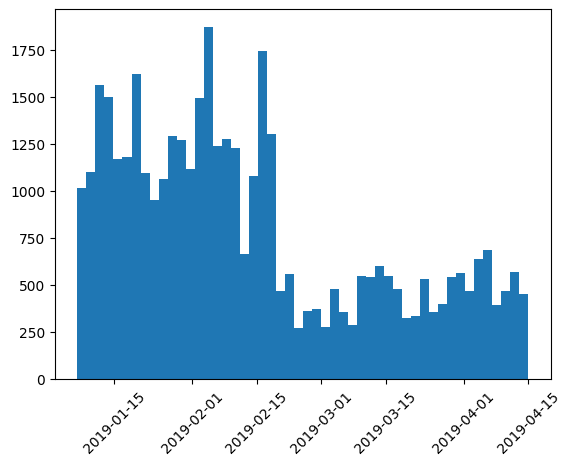

In [10]:
plt.hist(data["date"], bins=50)
plt.xticks(rotation=45);

In [11]:
data = data.explode("recommended_series_list")
data["recommended_series_list"] = pd.to_numeric(
    data["recommended_series_list"]
)

data["target"] = np.where(
    data2["series_id"] == data2["recommended_series_list"],
    1,
    0,
)
data

,timestamp,date,user_id,series_id,recommendation_id,vision_factor,recommendation_list_length,recommended_series_list,target
0,2019-01-07 09:01:26,2019-01-07,2254,19433,133389,0.50,10,14716,0
0,2019-01-07 09:01:26,2019-01-07,2254,19433,133389,0.50,10,3502,0
0,2019-01-07 09:01:26,2019-01-07,2254,19433,133389,0.50,10,15656,0
0,2019-01-07 09:01:26,2019-01-07,2254,19433,133389,0.50,10,13542,0
0,2019-01-07 09:01:26,2019-01-07,2254,19433,133389,0.50,10,19433,1
...,...,...,...,...,...,...,...,...,...
40674,2019-04-15 08:21:59,2019-04-15,1236,26642,138075,0.29,20,7424,0
40674,2019-04-15 08:21:59,2019-04-15,1236,26642,138075,0.29,20,7494,0
40674,2019-04-15 08:21:59,2019-04-15,1236,26642,138075,0.29,20,27275,0
40674,2019-04-15 08:21:59,2019-04-15,1236,26642,138075,0.29,20,364,0


In [12]:
data["user_id"].value_counts()

user_id
9957     1649
2954     1591
1278     1463
25167    1398
22354    1306
         ... 
40215       5
35063       5
19202       5
35482       5
12189       5
Name: count, Length: 11783, dtype: int64

In [23]:
before = data[data["date"] < dt.date(2019, 3, 1)]
train = data[(data["date"] >= dt.date(2019, 3, 1)) & (data["date"] <= dt.date(2019, 4, 1))]
val = data[(data["date"] >= dt.date(2019, 4, 2)) & (data["date"] <= dt.date(2019, 4, 8))]
test = data[(data["date"] >= dt.date(2019, 4, 9)) & (data["date"] <= dt.date(2019, 4, 15))]
print(before.shape, train.shape, val.shape, test.shape)

before_users = before["user_id"].unique()
train_users = train["user_id"].unique()
val_users = val["user_id"].unique()
test_users = test["user_id"].unique()
common_users = np.intersect1d(np.intersect1d(np.intersect1d(before_users, train_users), val_users), test_users)
print(before_users.shape, train_users.shape, val_users.shape, test_users.shape, common_users.shape)

before = before[before["user_id"].isin(common_users)]
train = train[train["user_id"].isin(common_users)]
val = val[val["user_id"].isin(common_users)]
test = test[test["user_id"].isin(common_users)]
print(before.shape, train.shape, val.shape, test.shape)

(423599, 9) (123386, 9) (31629, 9) (26460, 9)
(9564,) (3130,) (1350,) (1144,) (169,)
(29552, 9) (20526, 9) (7534, 9) (6607, 9)


In [24]:
before_items = before["recommended_series_list"].unique()
train_items = train["recommended_series_list"].unique()
val_items = val["recommended_series_list"].unique()
test_items = test["recommended_series_list"].unique()
common_items = np.intersect1d(np.intersect1d(np.intersect1d(before_items, train_items), val_items), test_items)
print(before_items.shape, train_items.shape, val_items.shape, test_items.shape, common_items.shape)

before = before[before["recommended_series_list"].isin(common_items)]
train = train[train["recommended_series_list"].isin(common_items)]
val = val[val["recommended_series_list"].isin(common_items)]
test = test[test["recommended_series_list"].isin(common_items)]
print(before.shape, train.shape, val.shape, test.shape)

(1519,) (1393,) (926,) (921,) (482,)
(20084, 9) (14269, 9) (5197, 9) (3822, 9)


In [25]:
before["user_id"].nunique(), before["recommended_series_list"].nunique()

(169, 482)

In [26]:
train["user_id"].nunique(), train["recommended_series_list"].nunique()

(169, 482)

In [28]:
val["user_id"].nunique(), val["recommended_series_list"].nunique()

(148, 482)

In [27]:
test["user_id"].nunique(), test["recommended_series_list"].nunique()

(132, 482)

In [30]:
test

,timestamp,date,user_id,series_id,recommendation_id,vision_factor,recommendation_list_length,recommended_series_list,target
39008,2019-04-09 00:41:53,2019-04-09,23176,181,224511,0.88,5,14716,0
39008,2019-04-09 00:41:53,2019-04-09,23176,181,224511,0.88,5,181,1
39008,2019-04-09 00:41:53,2019-04-09,23176,181,224511,0.88,5,22478,0
39008,2019-04-09 00:41:53,2019-04-09,23176,181,224511,0.88,5,24645,0
39008,2019-04-09 00:41:53,2019-04-09,23176,181,224511,0.88,5,23832,0
...,...,...,...,...,...,...,...,...,...
40673,2019-04-15 07:20:01,2019-04-15,15452,20058,293228,1.00,30,25840,0
40673,2019-04-15 07:20:01,2019-04-15,15452,20058,293228,1.00,30,13393,0
40673,2019-04-15 07:20:01,2019-04-15,15452,20058,293228,1.00,30,25622,0
40673,2019-04-15 07:20:01,2019-04-15,15452,20058,293228,1.00,30,15443,0


In [38]:
tmp = test.groupby(test.index).agg({"recommended_series_list": list, "target": list, "recommendation_list_length": len})
tmp

,recommended_series_list,target,recommendation_list_length
39008,"[14716, 181, 22478, 24645, 23832]","[0, 1, 0, 0, 0]",5
39011,"[26722, 9473, 6491, 16129, 23969, 8216, 10897,...","[0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...",20
39027,"[24889, 1221, 2082, 18603, 10299, 15426, 13734...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, ...",29
39031,"[14716, 22478, 3280, 26008, 19379, 23832]","[0, 0, 0, 0, 1, 0]",6
39033,"[14716, 181, 22478, 24645, 23832]","[0, 0, 0, 1, 0]",5
...,...,...,...
40663,"[28098, 26301, 557, 12133, 18514, 15641]","[0, 1, 0, 0, 0, 0]",6
40664,"[22550, 4671, 4928, 17972, 13172, 27503, 17489]","[0, 0, 0, 0, 1, 0, 0]",7
40666,"[7990, 28700, 5475, 3992, 27710, 5444, 668, 26...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, ...",23
40669,"[24124, 5353, 28191, 3343, 19139, 11420, 7005,...","[0, 0, 0, 0, 0, 0, 0, 0, 0]",9


In [43]:
tmp["recommendation_list_length"].value_counts().sort_index()

recommendation_list_length
1      1
3      6
4     10
5     18
6     12
7     15
8      7
9     17
10     9
11     7
12     3
13     9
14     5
15    16
16     5
17     8
18     3
19    12
20    16
21     1
22     3
23    23
24     6
25    25
26     1
27     2
28     6
29     4
30     3
Name: count, dtype: int64

In [26]:
def parse(data):
    data = data.explode("recommended_series_list")
    data["recommended_series_list"] = pd.to_numeric(
        data["recommended_series_list"]
    )
    data["target"] = np.where(data["series_id"] == data["recommended_series_list"], 1, 0)

    return data

In [27]:
train = parse(train)
val = parse(val)
test = parse(test)

train.shape, val.shape, test.shape

((24929, 9), (31629, 9), (26460, 9))

In [19]:
train

,timestamp,date,user_id,series_id,recommendation_id,vision_factor,recommendation_list_length,recommended_series_list,target
35332,2019-03-26 00:02:20,2019-03-26,5714,22686,178179,1.00,15,1221,0
35332,2019-03-26 00:02:20,2019-03-26,5714,22686,178179,1.00,15,7727,0
35332,2019-03-26 00:02:20,2019-03-26,5714,22686,178179,1.00,15,18042,0
35332,2019-03-26 00:02:20,2019-03-26,5714,22686,178179,1.00,15,2328,0
35332,2019-03-26 00:02:20,2019-03-26,5714,22686,178179,1.00,15,1496,0
...,...,...,...,...,...,...,...,...,...
37013,2019-04-01 23:59:28,2019-04-01,30885,10593,130501,0.44,20,10593,1
37013,2019-04-01 23:59:28,2019-04-01,30885,10593,130501,0.44,20,27277,0
37013,2019-04-01 23:59:28,2019-04-01,30885,10593,130501,0.44,20,7424,0
37013,2019-04-01 23:59:28,2019-04-01,30885,10593,130501,0.44,20,7494,0


In [28]:
before

,timestamp,date,user_id,series_id,recommendation_id,vision_factor,recommendation_list_length,recommended_series_list
0,2019-01-07 09:01:26,2019-01-07,2254,19433,133389,0.50,10,"[14716, 3502, 15656, 13542, 19433, 275, 21941,..."
1,2019-01-07 09:03:08,2019-01-07,2702,9473,40459,0.31,30,"[14834, 21525, 2439, 2997, 8150, 2082, 9473, 2..."
2,2019-01-07 09:09:25,2019-01-07,6149,16187,119493,0.49,10,"[6854, 19911, 10228, 1483, 16806, 16187, 25786..."
3,2019-01-07 09:15:34,2019-01-07,36061,16187,9552,0.96,10,"[6854, 19911, 10228, 1483, 16806, 16187, 25786..."
4,2019-01-07 09:16:57,2019-01-07,27645,16187,9552,1.00,10,"[6854, 19911, 10228, 1483, 16806, 16187, 25786..."
...,...,...,...,...,...,...,...,...
35327,2019-03-25 23:31:12,2019-03-25,37903,18459,215144,0.99,6,"[23792, 2769, 26420, 18459, 9101, 10692]"
35328,2019-03-25 23:31:25,2019-03-25,2065,24331,53008,0.66,20,"[24331, 22261, 28326, 22574, 693, 11480, 18436..."
35329,2019-03-25 23:38:14,2019-03-25,11175,24820,219161,0.84,30,"[25621, 20058, 3343, 10874, 13172, 24258, 1752..."
35330,2019-03-25 23:44:19,2019-03-25,32547,18465,165711,0.31,20,"[2481, 1092, 5829, 7409, 17756, 21261, 3114, 8..."


In [12]:
data2 = data.explode("recommended_series_list")
data2["recommended_series_list"] = pd.to_numeric(
    data2["recommended_series_list"]
)

data2["target"] = np.where(
    data2["series_id"] == data2["recommended_series_list"],
    1,
    0,
)

data2["random_score"] = np.random.uniform(0, 1, size=len(data2))
data2["best_score"] = data2["target"].astype(np.float64)
data2["worst_score"] = ((data2["target"] + 1) % 2).astype(np.float64)

data2.head(5)

,timestamp,date,user_id,recommendation_id,vision_factor,recommendation_list_length,item_id,target,random_score,best_score,worst_score
0,2019-01-07 09:01:26,2019-01-07,2254,133389,0.5,10,14716,0,0.637143,0.0,1.0
0,2019-01-07 09:01:26,2019-01-07,2254,133389,0.5,10,3502,0,0.201216,0.0,1.0
0,2019-01-07 09:01:26,2019-01-07,2254,133389,0.5,10,15656,0,0.417051,0.0,1.0
0,2019-01-07 09:01:26,2019-01-07,2254,133389,0.5,10,13542,0,0.326607,0.0,1.0
0,2019-01-07 09:01:26,2019-01-07,2254,133389,0.5,10,19433,1,0.592803,1.0,0.0


In [15]:
from torch import tensor
from torchmetrics.retrieval import RetrievalNormalizedDCG

indexes = tensor(data2.index)
target = tensor(data2["target"].to_numpy())
ndcg = RetrievalNormalizedDCG(top_k=4)

preds = tensor(data2["worst_score"].to_numpy())
print(f"worst ndcg@4: {ndcg(preds, target, indexes=indexes)}")

preds = tensor(data2["best_score"].to_numpy())
print(f"best ndcg@4: {ndcg(preds, target, indexes=indexes)}")

preds = tensor(data2["random_score"].to_numpy())
print(f"random ndcg@4: {ndcg(preds, target, indexes=indexes)}")

worst ndcg: 0.0
best ndcg: 1.0
random ndcg: 0.20489589869976044


In [16]:
data3 = data2.groupby(data2.index).agg({"target": list, "worst_score": list, "best_score": list, "random_score": list})

auc_roc_per_list = []
for row in data3.itertuples():
    auc_roc_per_list.append(roc_auc_score(row.target, row.worst_score))
print(f"worst auc: {np.mean(auc_roc_per_list)}")

auc_roc_per_list = []
for row in data3.itertuples():
    auc_roc_per_list.append(roc_auc_score(row.target, row.best_score))
print(f"best auc: {np.mean(auc_roc_per_list)}")

auc_roc_per_list = []
for row in data3.itertuples():
    auc_roc_per_list.append(roc_auc_score(row.target, row.random_score))
print(f"random auc: {np.mean(auc_roc_per_list)}")

worst auc: 0.0
best auc: 1.0
random auc: 0.500206814575237


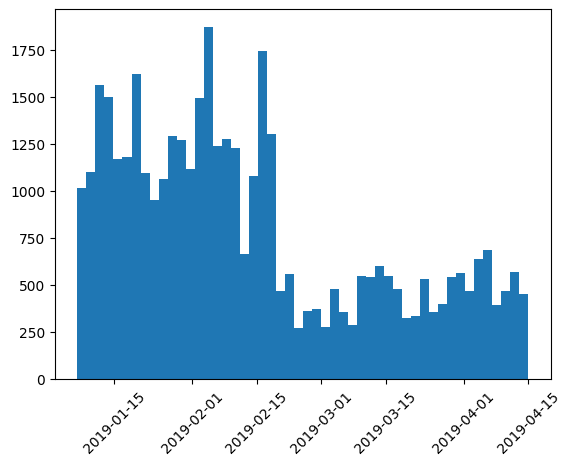

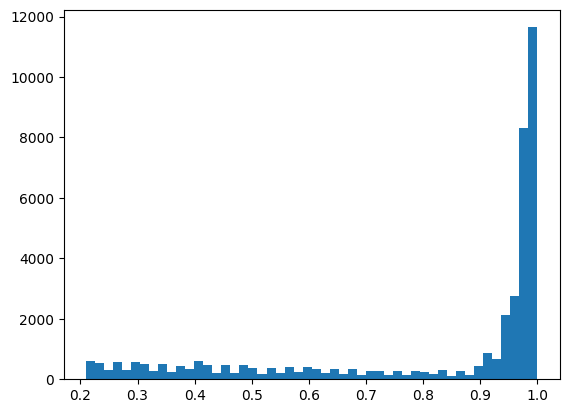

In [12]:
plt.hist(data["vision_factor"], bins=50);

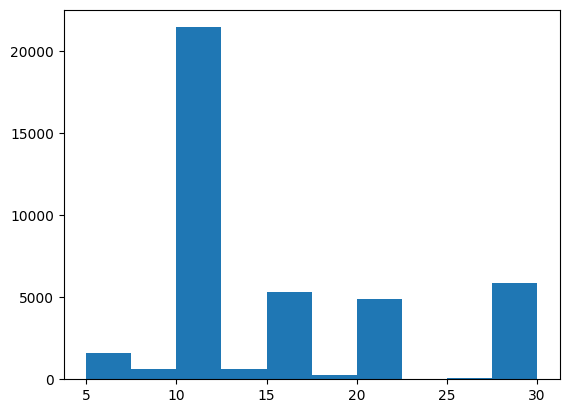

In [13]:
plt.hist(data["recommendation_list_length"]);

In [12]:
data["recommendation_list_length"].value_counts()

recommendation_list_length
10    22667
30     6921
15     6583
20     5968
12     4062
6      1856
11      780
9       607
14      403
13      378
29      287
22      224
19      220
5       216
8       128
16      127
18      103
28       91
4        71
17       57
27       48
7        39
3        28
24       21
21       13
26       10
25        7
2         6
23        4
1         3
Name: count, dtype: int64

In [9]:
# Select only movies from item types
interactions = interactions[interactions["item_type"] == 0]
# Select only clicks as an interaction type
interactions = interactions[interactions["interaction_type"] == 0]
# Keep only logs from recommendations
interactions = interactions[interactions["recommendation_id"] != -1]

print(interactions.shape)

interactions["timestamp"] = pd.to_datetime(
    interactions["utc_ts_milliseconds"],
    unit="ms",
)

impressions_dl = impressions_dl.explode("recommended_series_list")
impressions_dl["recommended_series_list"] = pd.to_numeric(
    impressions_dl["recommended_series_list"]
)

# Join positive interactions (clicks) with negative interactions (impressions)
interactions = interactions.merge(impressions_dl, "inner", "recommendation_id")

# Mark positive interactions with 1 and negative with 0
interactions["target"] = np.where(
    interactions["series_id"] == interactions["recommended_series_list"],
    1,
    0,
)
interactions["target"] = interactions["target"].astype("int32")

(51928, 11)


In [44]:
interactions

,utc_ts_milliseconds,user_id,item_id,series_id,episode_number,series_length,item_type,recommendation_id,interaction_type,vision_factor,explicit_rating,timestamp,row_position,recommendation_list_length,recommended_series_list,target
0,1551095020000,9147,61034,23080,1,1,0,107260,0,0.01,-1.0,2019-02-25 11:43:40,3,12,16194,0
1,1551095020000,9147,61034,23080,1,1,0,107260,0,0.01,-1.0,2019-02-25 11:43:40,3,12,18689,0
2,1551095020000,9147,61034,23080,1,1,0,107260,0,0.01,-1.0,2019-02-25 11:43:40,3,12,9473,0
3,1551095020000,9147,61034,23080,1,1,0,107260,0,0.01,-1.0,2019-02-25 11:43:40,3,12,13943,0
4,1551095020000,9147,61034,23080,1,1,0,107260,0,0.01,-1.0,2019-02-25 11:43:40,3,12,17297,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
767073,1549022895000,40763,90910,19532,1,1,0,132437,0,0.26,-1.0,2019-02-01 12:08:15,3,30,24429,0
767074,1549022895000,40763,90910,19532,1,1,0,132437,0,0.26,-1.0,2019-02-01 12:08:15,3,30,4347,0
767075,1549022895000,40763,90910,19532,1,1,0,132437,0,0.26,-1.0,2019-02-01 12:08:15,3,30,2484,0
767076,1549022895000,40763,90910,19532,1,1,0,132437,0,0.26,-1.0,2019-02-01 12:08:15,3,30,1881,0


In [47]:
interactions["recommendation_id"].nunique()

47658

In [49]:
interactions[interactions["target"] == 1]

,utc_ts_milliseconds,user_id,item_id,series_id,episode_number,series_length,item_type,recommendation_id,interaction_type,vision_factor,explicit_rating,timestamp,row_position,recommendation_list_length,recommended_series_list,target
11,1551095020000,9147,61034,23080,1,1,0,107260,0,0.01,-1.0,2019-02-25 11:43:40,3,12,23080,1
33,1551048253000,36692,15925,18387,1,3,0,306523,0,0.94,-1.0,2019-02-24 22:44:13,0,30,18387,1
49,1551056298000,17473,9398,14953,1,1,0,111683,0,0.22,-1.0,2019-02-25 00:58:18,0,14,14953,1
63,1551071872000,19541,9398,14953,1,1,0,81974,0,0.96,-1.0,2019-02-25 05:17:52,0,14,14953,1
84,1551052699000,3619,24030,3738,1,1,0,83883,0,0.58,-1.0,2019-02-24 23:58:19,2,15,3738,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
767010,1549015827000,35554,48774,18840,1,3,0,211490,0,0.89,-1.0,2019-02-01 10:10:27,3,15,18840,1
767024,1549018572000,18375,96804,5787,1,1,0,126493,0,0.01,-1.0,2019-02-01 10:56:12,0,11,5787,1
767036,1549019705000,25109,96079,28527,1,1,0,275390,0,0.42,-1.0,2019-02-01 11:15:05,9,10,28527,1
767046,1549021247000,28512,96079,28527,1,1,0,178963,0,0.04,-1.0,2019-02-01 11:40:47,9,10,28527,1


In [ ]:
interactions

In [10]:
interactions.groupby("target").count()

,utc_ts_milliseconds,user_id,item_id,series_id,episode_number,series_length,item_type,recommendation_id,interaction_type,vision_factor,explicit_rating,timestamp,row_position,recommendation_list_length,recommended_series_list
target,,,,,,,,,,,,,,,
0,715150,715150,715150,715150,715150,715150,715150,715150,715150,715150,715150,715150,715150,715150,715150
1,51928,51928,51928,51928,51928,51928,51928,51928,51928,51928,51928,51928,51928,51928,51928


In [15]:
interactions[interactions["target"] == 1].groupby("recommendation_id").agg({"user_id": "count"}).sort_values("user_id")

,user_id
recommendation_id,
9,1
202248,1
202253,1
202255,1
202258,1
...,...
221018,10
158075,10
278228,10


In [18]:
interactions[interactions["target"] == 1][interactions["recommendation_id"]==29314]

/tmp/ipykernel_102360/1282205619.py:1: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  interactions[interactions["target"] == 1][interactions["recommendation_id"]==29314]


,utc_ts_milliseconds,user_id,item_id,series_id,episode_number,series_length,item_type,recommendation_id,interaction_type,vision_factor,explicit_rating,timestamp,row_position,recommendation_list_length,recommended_series_list,target
647609,1547993465000,35814,54059,24820,1,1,0,29314,0,0.20,-1.0,2019-01-20 14:11:05,0,10,24820,1
647619,1547996233000,16630,54059,24820,1,1,0,29314,0,1.00,-1.0,2019-01-20 14:57:13,0,10,24820,1
647631,1547993319000,372,113547,9396,1,1,0,29314,0,0.98,-1.0,2019-01-20 14:08:39,0,10,9396,1
647641,1547995729000,6198,113547,9396,1,1,0,29314,0,0.98,-1.0,2019-01-20 14:48:49,0,10,9396,1
647647,1547996978000,32221,110119,6186,1,1,0,29314,0,0.92,-1.0,2019-01-20 15:09:38,0,10,6186,1
647657,1547990126000,35814,110119,6186,1,1,0,29314,0,0.01,-1.0,2019-01-20 13:15:26,0,10,6186,1
647676,1547997568000,17367,133248,1163,1,1,0,29314,0,0.94,-1.0,2019-01-20 15:19:28,0,10,1163,1
647686,1547991986000,35814,133248,1163,1,1,0,29314,0,0.26,-1.0,2019-01-20 13:46:26,0,10,1163,1
647696,1547998026000,7049,133248,1163,1,1,0,29314,0,1.00,-1.0,2019-01-20 15:27:06,0,10,1163,1
647701,1548000234000,16663,113547,9396,1,1,0,29314,0,0.99,-1.0,2019-01-20 16:03:54,0,10,9396,1
